This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it contains runnable code blocks, text, figures, section titles, and a bunch of edits by Matthew Kehoe.

This notebook was generated for TensorFlow 2.6.

## The Transformer architecture

Starting in 2017, a new model architecture started overtaking recurrent neural networks across most natural language processing tasks: the Transformer.

Transformers were introduced in the seminal paper [Attention is all you need](https://arxiv.org/abs/1706.03762) by Vaswani et al. The gist of the paper is right there in the title: as it turned out, a simple mechanism called “neural attention” could be used to build powerful sequence models that didn't feature any recurrent layers or convolution layers.

This finding unleashed nothing short of a revolution in natural language processing—and beyond. Neural attention has fast become one of the most influential ideas in deep learning. In this section, you'll get an in-depth explanation of how it works and why it has proven so effective for sequence data. We'll then leverage self-attention to create a Transformer encoder, one of the basic components of the Transformer architecture, and we'll apply it to the IMDB movie review classification task.

### Understanding self-attention

As you're going through this book, you may be skimming some parts and attentively reading others, depending on what your goals or interests are. What if your models did the same? It's a simple yet powerful idea: not all input information seen by a model is equally important to the task at hand, so models should "pay more attention" to some features and "pay less attention" to other features.

Does that sound familiar? You've already encountered a similar concept twice in
this book:

- Max pooling in convnets looks at a pool of features in a spatial region and
selects just one feature to keep. That's an “all or nothing” form of attention:
keep the most important feature and discard the rest.
- TF-IDF normalization assigns importance scores to tokens based on how much
information different tokens are likely to carry. Important tokens get boosted
while irrelevant tokens get faded out. That's a continuous form of attention.

There are many different forms of attention you could imagine, but they all start by computing importance scores for a set of features, with higher scores for more relevant features and lower scores for less relevant ones (see figure below). How these scores should be computed, and what you should do with them, will vary from approach to approach.

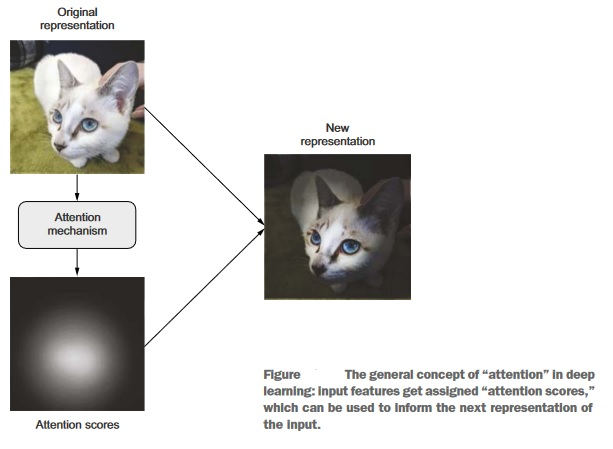

Crucially, this kind of attention mechanism can be used for more than just highlighting or erasing certain features. It can be used to make features context-aware. You've just learned about word embeddings—vector spaces that capture the “shape” of the semantic relationships between different words. In an embedding space, a single word has a fixed position—a fixed set of relationships with every other word in the space. But that's not quite how language works: the meaning of a word is usually context-specific. When you
mark the date, you're not talking about the same “date” as when you go on a date, nor is it the kind of date you'd buy at the market. When you say, “I'll see you soon,” the meaning of the word "see" is subtly different from the "see" in “I'll see this project to its end” or “I see what you mean.” And, of course, the meaning of pronouns like “he,” “it,” “in,” etc., is entirely sentence-specific and can even change multiple times within a single sentence.

Clearly, a smart embedding space would provide a different vector representation
for a word depending on the other words surrounding it. That's where self-attention comes in. The purpose of self-attention is to modulate the representation of a token by using the representations of related tokens in the sequence. This produces context aware token representations. Consider an example sentence: “The train left the station on time.” Now, consider one word in the sentence: station. What kind of station are we talking about? Could it be a radio station? Maybe the International Space Station? Let's figure it out algorithmically via self-attention (see figure below).

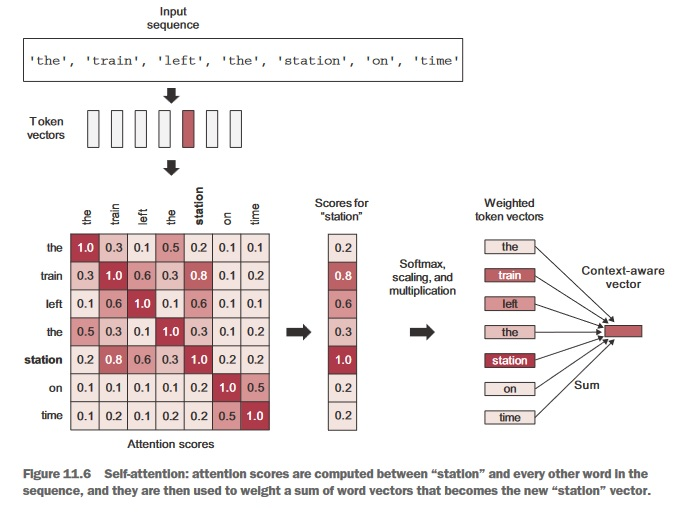

Step 1 is to compute relevancy scores between the vector for “station” and every other word in the sentence. These are our “attention scores.” We're simply going to use the dot product between two word vectors as a measure of the strength of their relationship. It's a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other long before Transformers. In practice, these scores will also go through a scaling function and a softmax, but for
now, that's just an implementation detail.

Step 2 is to compute the sum of all word vectors in the sentence, weighted by our relevancy scores. Words closely related to “station” will contribute more to the sum (including the word “station” itself), while irrelevant words will contribute almost nothing. The resulting vector is our new representation for “station”: a representation that incorporates the surrounding context. In particular, it includes part of the “train” vector, clarifying that it is, in fact, a “train station.”

You'd repeat this process for every word in the sentence, producing a new
sequence of vectors encoding the sentence. Let's see it in NumPy-like pseudocode:

In [ ]:
# Psuedocode

def self_attention(input_sequence):
    output = np.zeros(shape=input_sequence.shape)
    for i, pivot_vector in enumerate(input_sequence):                           # Iterate over each token in the input sequence
        scores = np.zeros(shape=(len(input_sequence),))
        for j, vector in enumerate(input_sequence):
            scores[j] = np.dot(pivot_vector, vector.T)                          # Compute the dot product (attention score) between the token and every other token
        scores /= np.sqrt(input_sequence.shape[1])                              # Scale by a normalization factor
        scores = softmax(scores)                                                # and apply a softmax
        new_pivot_representation = np.zeros(shape=pivot_vector.shape)
        for j, vector in enumerate(input_sequence):
            new_pivot_representation += vector * scores[j]                      # Take the sum of all tokens weighted by the attention scores
        output[i] = new_pivot_representation                                    # That sum is our output
    return output

Of course, in practice you'd use a vectorized implementation. Keras has a built-in layer to handle it: the `MultiHeadAttention` layer. Here's how you would use it:

In [ ]:
num_heads = 4
embed_dim = 256
mha_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
outputs = mha_layer(inputs, inputs, inputs)

Reading this, you're probably wondering
- Why are we passing the inputs to the layer three times? That seems redundant.
- What are these “multiple heads” we're referring to? That sounds intimidating—
do they also grow back if you cut them?

Both of these questions have straightforward answers. Let's take a look.

#### Generalized self-attention: the query-key-value model

### Multi-head attention

### The Transformer encoder

**Getting the data**

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

**Preparing the data**

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

**Vectorizing the data**

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Transformer encoder implemented as a subclassed `Layer`**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

**Using the Transformer encoder for text classification**

In [ ]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

**Training and evaluating the Transformer encoder based model**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

#### Using positional encoding to re-inject order information

**Implementing positional embedding as a subclassed layer**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### Putting it all together: A text-classification Transformer

**Combining the Transformer encoder with positional embedding**

In [ ]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

### When to use sequence models over bag-of-words models?